In [23]:
import datacube
import matplotlib.pyplot as plt
from datacube import helpers
from datacube.utils import geometry
from scipy import ndimage
import xarray as  xr
import numpy as np
import sys
sys.path.append('/g/data/u46/users/sc0554/dea-notebooks/10_Scripts/')
from DEAPlotting import display_map

In [18]:
dc = datacube.Datacube(app='lccs_loader')
# dc=datacube.Datacube(config='/home/547/sc0554/datacube.conf', env='lccs_dev')

In [28]:
product = 'fc_percentile_albers_annual'
product = 'ls8_nbart_albers'

minx = 1199685
maxx = 1299651
miny = -3800197
maxy = -3700025

# minx = 1500000
# maxx = 1600000
# miny = -2200000
# maxy = -2100000

# minx = 1400000
# maxx = 1500000
# miny = -4100000
# maxy = -4000000

query = {'time': ('2015-01-01', '2015-12-31')}
query['x'] = (minx, maxx)
query['y'] = (miny, maxy)
query['crs'] = 'EPSG:3577'

In [29]:
display_map((miny, maxy), (minx, maxx))

In [30]:
data = dc.load(product=product, **query)

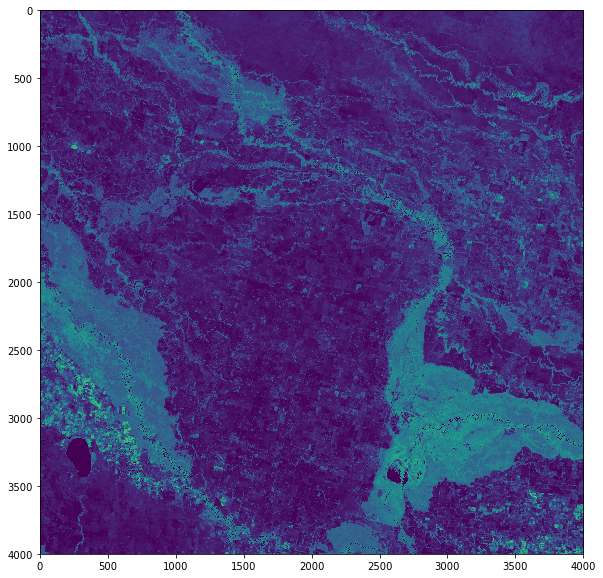

In [33]:
fig, ax = plt.subplots(ncols=1, figsize=(20,10))
ax.imshow(data.PV_PC_10.isel(time=0))

In [16]:
from datacube.utils import geometry


In [34]:
out = data.PV_PC_90
out = out.drop('time')
out.attrs['crs']= 'EPSG:3577' #geometry.CRS(data.crs)

In [35]:
out.to_netcdf('FC_barmah.nc')

In [36]:
pvmax = data.PV_PC_90.isel(time=0).data
pvmin = data.PV_PC_10.isel(time=0).data
cultivated_index = (pvmax-pvmin)#/(100-pvmin)
cultivated_index_filt = np.where(cultivated_index > 45, 1, 0)
cultivated_index_filt = cultivated_index_filt.astype(float)
cultivated_index_filt = ndimage.median_filter(cultivated_index_filt, 4)

In [37]:
# fig, ax = plt.subplots(ncols=1, figsize=(15,5))
# ax.hist(cultivated_index.data.ravel())

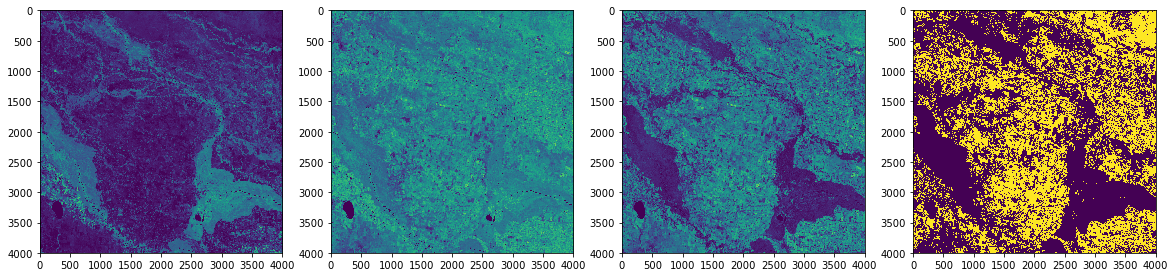

In [38]:
fig, ax = plt.subplots(ncols=4, figsize=(20,10))
ax[0].imshow(data.PV_PC_10.isel(time=0))
ax[1].imshow(data.PV_PC_90.isel(time=0))
ax[2].imshow(cultivated_index)
ax[3].imshow(cultivated_index_filt)

In [41]:
meta_d = data.isel(time=0).squeeze().drop('time')

In [42]:
out = xr.Dataset({'cult':(meta_d.dims,cultivated_index_filt)}, coords=meta_d.coords, attrs=meta_d.attrs)
out.attrs['crs']=geometry.CRS(meta_d.crs)

In [43]:
helpers.write_geotiff('cult2_alb_bar.tif', out)